# Model is in progress of a training loop update

In [1]:
import numpy as np 
import pandas as pd 
import torch # framework
import torch.nn as nn # neural net framework
import torchvision # dataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt # data visualization
from torchvision import transforms

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparamters = config of the model
input_size = 784 # images are 28x28
hidden_size = 100
num_classes = 10 # 0-9 digits
batch_size = 100

In [3]:
class DigitRecogDataset(Dataset):
    def __init__(self,csv_file,has_labels=True,transform=None):
        self.data = pd.read_csv(csv_file)
        self.has_labels = has_labels
        self.transform = transform

        if self.has_labels:
            # The first column of train.csv has labels for data
            self.labels = self.data.iloc[:,0].values
            self.images = self.data.iloc[:,1:].values
        else:
            # The test.csv does not contain a label
            self.images = self.data.values

    def __len__(self):
        return len(self.images)

    def __getitem__(self,index):
        image = self.images[index].reshape(28,28).astype('float32')/255.0
        image = torch.tensor(image).unsqueeze(0) # (1,28,28)

        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = torch.tensor(self.labels[index],dtype=torch.long)
            return image, label
        else:
            return image

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # normalize pixel values
])

In [4]:
# Dataset
from torch.utils.data import random_split, DataLoader

test_ds = DigitRecogDataset(
    csv_file="/kaggle/input/digit-recognizer/test.csv",
    has_labels=False,
    transform=transform
)
train_ds = DigitRecogDataset(
    csv_file="/kaggle/input/digit-recognizer/train.csv",
    has_labels=True,
    transform=transform
)

#split train_ds into a sperate validation set (val_ds)
#currently set to [10%] to give more data for training
val_frac = 0.1
n_val = int(len(train_ds) * val_frac)
n_train = len(train_ds) - n_val
train_ds, val_ds = random_split(train_ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds,batch_size=batch_size,shuffle=False)

torch.Size([100, 1, 28, 28]) torch.Size([100])


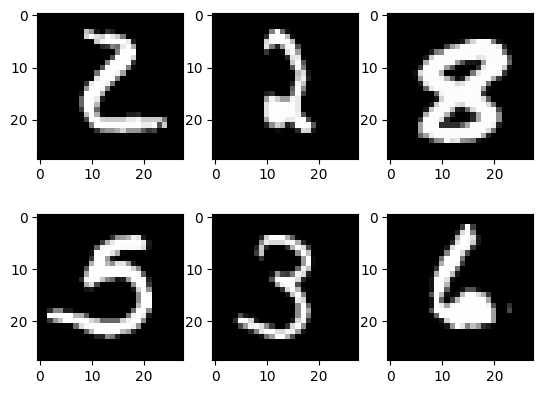

In [5]:
# visualize
examples = iter(train_loader)
samples, labels = next(examples) # torch objects have the samples and labels atributes
print(samples.shape, labels.shape)

# torch.Size([100, 1, 28, 28]) torch.Size([100])
# 100 samples, 1 channel of color, 28 width, 28 length
# Each class label has one value

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [6]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

model = NeuralNet(input_size, hidden_size, num_classes)

In [7]:
# Training Loop
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

learning_rate = 1e-3
num_epochs = 50
n_steps = len(train_loader)

best_acc = 0.0
best_state = None

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # applies softmax automatically
optimizer = AdamW(model.parameters(), lr = learning_rate, weight_decay = 1e-4)
model.to(device)

# Learning Rate Scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=n_steps,
    pct_start=0.2, # warmup
    anneal_strategy='cos'
)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
    # [100, 1, 28, 28] --> [100, 784]
        images = images.reshape(-1, 28*28).to(device) # -1 forces pytoch to automatically find the dimension
        labels = labels.to(device)

    # forward
        outputs = model(images)
        loss = criterion(outputs, labels) # predicted, actual

    # backward
        optimizer.zero_grad() # empty gradients
        loss.backward() # backpropagation

    # gradient clip
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)

    # step
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()*labels.size(0)

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            preds =  model(images).argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = 100.0*(correct/total)

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}

    print(f"Epoch {epoch+1}/{num_epochs} | loss {running_loss/len(train_ds):.4f} | val {val_acc:.2f}%")

# load the current best model as a checkpoint
# saves only the best model for submission

if best_state:
    model.load_state_dict(best_state)
    model.to(device)

Epoch 1/50 | loss 1.6447 | val 82.07%
Epoch 2/50 | loss 0.9796 | val 88.50%
Epoch 3/50 | loss 0.8478 | val 90.67%
Epoch 4/50 | loss 0.7930 | val 92.17%
Epoch 5/50 | loss 0.7427 | val 93.81%
Epoch 6/50 | loss 0.6998 | val 95.10%
Epoch 7/50 | loss 0.6670 | val 95.81%
Epoch 8/50 | loss 0.6467 | val 95.95%
Epoch 9/50 | loss 0.6326 | val 96.62%
Epoch 10/50 | loss 0.6202 | val 97.36%
Epoch 11/50 | loss 0.6131 | val 97.12%
Epoch 12/50 | loss 0.6049 | val 97.07%
Epoch 13/50 | loss 0.5982 | val 97.26%
Epoch 14/50 | loss 0.5940 | val 97.17%
Epoch 15/50 | loss 0.5904 | val 97.40%
Epoch 16/50 | loss 0.5860 | val 97.31%
Epoch 17/50 | loss 0.5832 | val 97.40%
Epoch 18/50 | loss 0.5804 | val 97.52%
Epoch 19/50 | loss 0.5766 | val 97.88%
Epoch 20/50 | loss 0.5751 | val 97.52%
Epoch 21/50 | loss 0.5718 | val 97.69%
Epoch 22/50 | loss 0.5704 | val 97.79%
Epoch 23/50 | loss 0.5677 | val 97.71%
Epoch 24/50 | loss 0.5668 | val 97.98%
Epoch 25/50 | loss 0.5646 | val 97.79%
Epoch 26/50 | loss 0.5633 | val 97

In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        # handle 2- or 3-tuple batches robustly
        if isinstance(batch, (list, tuple)):
            images, labels = batch[0], batch[1]
        else:
            raise RuntimeError("Unexpected batch type; expected tuple/list")

        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Validation accuracy: {100 * correct / total:.2f}%")


Validation accuracy: 98.10%


In [9]:
# Model Submission

model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.reshape(-1,28*28).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({
    "ImageID": range(1, len(predictions)+1),
    "Label": predictions
})

submission.to_csv("submission.csv", index=False)